In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from tensorflow.keras.utils import to_categorical
from scipy.fft import rfft
from statsmodels.tsa.stattools import acf
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
# --- 1. Simulation Function ---
def simulate_black_hole_lightcurve(fs, fc, fm, qpo_amplitude, duration,
                                   noise_mean=0, noise_std=0.5,
                                   include_qpo=True, modulation_index=0.5):
    """
    Simulate a black hole light curve with stochastic noise and an amplitude-modulated QPO signal.

    Parameters:
        fs : int
            Sampling frequency (Hz)
        fc : float
            Carrier frequency (Hz) for QPO
        fm : float
            Modulating frequency (Hz) for QPO
        qpo_amplitude : float
            Amplitude of the carrier signal (QPO)
        duration : float
            Duration of lightcurve (seconds)
        noise_mean : float
            Mean of the Gaussian noise
        noise_std : float
            Standard deviation of the Gaussian noise
        include_qpo : bool
            Whether to include the QPO signal
        modulation_index : float
            Modulation index for AM signal

    Returns:
        t : np.ndarray
            Time array
        flux : np.ndarray
            Normalized flux array
    """
    # Time array
    t = np.arange(0, duration, 1/fs)

    # White noise
    white_noise = np.random.normal(noise_mean, noise_std, size=len(t))
    white_noise = np.exp(white_noise)

    if include_qpo and qpo_amplitude > 0:
        # Modulating signal
        msg = qpo_amplitude * np.cos(2 * np.pi * fm * t)

        # Carrier signal
        carrier = qpo_amplitude * np.cos(2 * np.pi * fc * t)

        # AM QPO signal
        qpo = carrier * (1 + modulation_index * msg / qpo_amplitude)
    else:
        qpo = 0

    # Combine noise and QPO signal
    flux = white_noise + qpo

    # Normalize
    flux = (flux - np.mean(flux)) / np.std(flux)

    return t, flux

In [4]:
def generate_dataset_with_fc_amp(output_dir, num_samples=5000,
                                 fs=1, duration=512,
                                 modulation_index=0.5,
                                 amp_range=(0.1, 1.0)):
    """
    Generate a dataset of light curves with fc and amp labels for conditional GAN/SBI.

    Stores:
        X: (num_samples, 512, 1) - light curves
        y: (num_samples, 3) - [fc, amp, is_qpo]

    Parameters:
        output_dir : str
            Path to save dataset
        num_samples : int
            Total number of samples (half QPO, half non-QPO)
        fs : int
            Sampling frequency
        duration : int
            Light curve length in seconds
        modulation_index : float
            AM index for QPO
        amp_range : tuple
            Amplitude range (min, max)
    """
    os.makedirs(output_dir, exist_ok=True)
    seq_length = int(duration * fs)
    X, y = [], []

    for _ in range(num_samples // 2):
        fc = np.random.uniform(0.01, 1.0)
        fm = np.random.uniform(0.005, 0.1)
        amp = np.random.uniform(*amp_range)

        # --- QPO light curve ---
        t, flux_qpo = simulate_black_hole_lightcurve(
            fs, fc, fm, amp, duration, include_qpo=True,
            modulation_index=modulation_index
        )
        X.append(flux_qpo[:seq_length].reshape(-1, 1))
        y.append([fc, amp, 1])  # label: 1 = QPO

        # --- Non-QPO light curve ---
        _, flux_non_qpo = simulate_black_hole_lightcurve(
            fs, fc, fm, amp, duration, include_qpo=False,
            modulation_index=modulation_index
        )
        X.append(flux_non_qpo[:seq_length].reshape(-1, 1))
        y.append([fc, amp, 0])  # label: 0 = non-QPO

    # Convert and save
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    np.savez_compressed(os.path.join(output_dir, "data_fc_amp.npz"), X=X, y=y)
    print(
        f"✅ Saved dataset to {output_dir}/data_fc_amp.npz with shape X: {X.shape}, y: {y.shape}")

In [5]:
output_folder = "qpo_physical_dataset/dataset_fc_amp"

generate_dataset_with_fc_amp(
    output_dir=output_folder,
    num_samples=1000,
    amp_range=(0.6, 1.0)
)

✅ Saved dataset to qpo_physical_dataset/dataset_fc_amp/data_fc_amp.npz with shape X: (1000, 512, 1), y: (1000, 3)


In [6]:
def load_physical_conditional_dataset(npz_path, batch_size=64, test_size=0.2):
    """
    Load dataset with labels = [fc, amp, is_qpo]
    Returns tf.data.Dataset of (X, [fc, amp, is_qpo])
    """
    data = np.load(npz_path)
    X = data["X"].astype(np.float32)         # shape: (N, 512, 1)
    y = data["y"].astype(np.float32)         # shape: (N, 3)

    # Split
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Make tf.data datasets
    train_ds = tf.data.Dataset.from_tensor_slices(
        (X_train, y_train)).shuffle(10000).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices(
        (X_val, y_val)).batch(batch_size)

    return train_ds, val_ds

In [7]:
def build_full_conditional_generator(latent_dim=100, condition_dim=3, seq_length=512):
    noise_input = tf.keras.Input(shape=(latent_dim,))
    condition_input = tf.keras.Input(shape=(condition_dim,))  # fc, amp, is_qpo

    x = tf.keras.layers.Concatenate()([noise_input, condition_input])
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(seq_length * 32)(x)
    x = tf.keras.layers.Reshape((seq_length, 32))(x)
    x = tf.keras.layers.GaussianNoise(0.05)(x)
    x = tf.keras.layers.GRU(64, return_sequences=True)(x)
    output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(x)

    return tf.keras.Model([noise_input, condition_input], output)


def build_full_conditional_discriminator(seq_length=512, condition_dim=3):
    series_input = tf.keras.Input(shape=(seq_length, 1))
    condition_input = tf.keras.Input(shape=(condition_dim,))  # fc, amp, is_qpo

    condition_expanded = tf.keras.layers.RepeatVector(seq_length)(condition_input)
    x = tf.keras.layers.Concatenate()([series_input, condition_expanded])

    x = tf.keras.layers.GRU(64, return_sequences=True)(x)
    x = tf.keras.layers.GRU(32)(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model([series_input, condition_input], output)


class ConditionalTimeSeriesGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.gen_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.disc_optimizer = tf.keras.optimizers.Adam(1e-4)

    def compile(self):
        super().compile()

    @tf.function
    def train_step(self, data):
        real_series, labels = data
        batch_size = tf.shape(real_series)[0]
        noise = tf.random.normal([batch_size, self.latent_dim])

        # === Train Discriminator ===
        with tf.GradientTape() as disc_tape:
            fake_series = self.generator([noise, labels], training=True)
            real_output = self.discriminator([real_series, labels], training=True)
            fake_output = self.discriminator([fake_series, labels], training=True)

            real_labels = tf.ones((batch_size, 1)) * 0.9  # Label smoothing
            fake_labels = tf.zeros((batch_size, 1))
            disc_loss = self.loss_fn(real_labels, real_output) + self.loss_fn(fake_labels, fake_output)

        grads_disc = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_variables))

        # === Train Generator ===
        noise = tf.random.normal([batch_size, self.latent_dim])
        with tf.GradientTape() as gen_tape:
            generated_series = self.generator([noise, labels], training=True)
            fake_output = self.discriminator([generated_series, labels], training=True)
            gen_loss = self.loss_fn(tf.ones((batch_size, 1)), fake_output)

        grads_gen = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(grads_gen, self.generator.trainable_variables))

        return {"gen_loss": gen_loss, "disc_loss": disc_loss}


In [8]:
import matplotlib.pyplot as plt
from scipy.signal import welch
from statsmodels.tsa.stattools import acf
from scipy.stats import lognorm

def plot_psd(series, fs=1, label='PSD'):
    f, Pxx = welch(series, fs=fs, nperseg=256)
    plt.semilogy(f, Pxx, label=label)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Power Spectral Density")
    plt.legend()

def plot_acf(series, lags=100, label='ACF'):
    autocorr = acf(series, nlags=lags, fft=True)
    plt.plot(autocorr, label=label)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title("ACF")
    plt.legend()

def plot_flux_histogram(series, label='Generated'):
    shape, loc, scale = lognorm.fit(series - np.min(series) + 1e-6)
    x = np.linspace(np.min(series), np.max(series), 100)
    pdf = lognorm.pdf(x, shape, loc, scale)

    plt.hist(series, bins=40, density=True, alpha=0.6, label=f"{label} Flux")
    plt.plot(x, pdf, '--', label=f"LogNorm Fit ({label})")
    plt.xlabel("Flux")
    plt.ylabel("Density")
    plt.title("Flux Histogram with Log-normal Fit")
    plt.legend()


In [9]:
from matplotlib.backends.backend_pdf import PdfPages

class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, generator, val_dataset, latent_dim, num_samples=3, label=[0, 1], save_dir="gan_outputs"):
        super().__init__()
        self.generator = generator
        self.val_dataset = val_dataset
        self.latent_dim = latent_dim
        self.num_samples = num_samples
        self.label = tf.convert_to_tensor([label] * num_samples, dtype=tf.float32)
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        noise = tf.random.normal([self.num_samples, self.latent_dim])
        generated = self.generator([noise, self.label], training=False).numpy().squeeze()
        real_samples = next(iter(self.val_dataset))[0].numpy().squeeze()[:self.num_samples]

        pdf_path = os.path.join(self.save_dir, f"epoch_{epoch+1}.pdf")
        with PdfPages(pdf_path) as pdf:
            for i in range(self.num_samples):
                fig, axes = plt.subplots(1, 3, figsize=(18, 4))

                plt.sca(axes[0])
                plot_psd(generated[i], label='Generated')
                plot_psd(real_samples[i], label='Real')

                plt.sca(axes[1])
                plot_acf(generated[i], label='Generated')
                plot_acf(real_samples[i], label='Real')

                plt.sca(axes[2])
                plot_flux_histogram(generated[i], label='Generated')
                plot_flux_histogram(real_samples[i], label='Real')

                plt.suptitle(f"Sample {i + 1} – Epoch {epoch + 1}")
                plt.tight_layout()

                # ✅ Save this figure as one page in the PDF
                pdf.savefig(fig)
                plt.show(fig)
                plt.close(fig)

        print(f"📄 Saved PDF for epoch {epoch + 1} at: {pdf_path}")


In [10]:
import os
os.makedirs("saved_models", exist_ok=True)

# csv_logger = tf.keras.callbacks.CSVLogger("saved_models/conditional_gan_training_log.csv", append=False)

In [11]:
import csv

class ValidationLossLogger(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, latent_dim, generator, discriminator, csv_path="saved_models/cgan_phy_log_with_val.csv"):
        super().__init__()
        self.val_dataset = val_dataset
        self.latent_dim = latent_dim
        self.generator = generator
        self.discriminator = discriminator
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.csv_path = csv_path

        with open(self.csv_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["epoch", "gen_loss", "disc_loss", "val_gen_loss", "val_disc_loss"])

    def on_epoch_end(self, epoch, logs=None):
        val_gen_loss_total = 0.0
        val_disc_loss_total = 0.0
        batches = 0

        for real_series, labels in self.val_dataset:
            batch_size = tf.shape(real_series)[0]
            noise = tf.random.normal([batch_size, self.latent_dim])
            fake_series = self.generator([noise, labels], training=False)

            # Discriminator loss on validation data
            real_output = self.discriminator([real_series, labels], training=False)
            fake_output = self.discriminator([fake_series, labels], training=False)
            real_labels = tf.ones((batch_size, 1)) * 0.9
            fake_labels = tf.zeros((batch_size, 1))
            disc_loss = self.loss_fn(real_labels, real_output) + self.loss_fn(fake_labels, fake_output)

            # Generator loss on validation data
            fake_output = self.discriminator([fake_series, labels], training=False)
            gen_loss = self.loss_fn(tf.ones((batch_size, 1)), fake_output)

            val_gen_loss_total += gen_loss.numpy()
            val_disc_loss_total += disc_loss.numpy()
            batches += 1

        avg_gen = val_gen_loss_total / batches
        avg_disc = val_disc_loss_total / batches

        with open(self.csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch + 1,
                logs["gen_loss"],
                logs["disc_loss"],
                avg_gen,
                avg_disc
            ])
        print(f"✅ Logged validation losses (gen: {avg_gen:.4f}, disc: {avg_disc:.4f})")


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 1.3779 - gen_loss: 0.7483

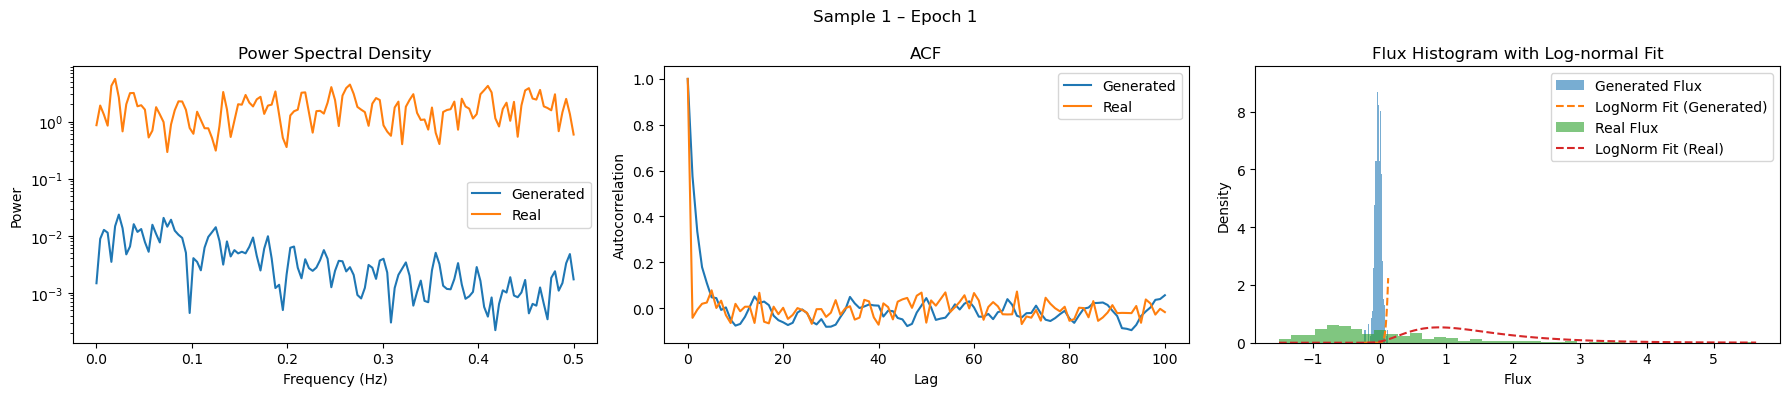

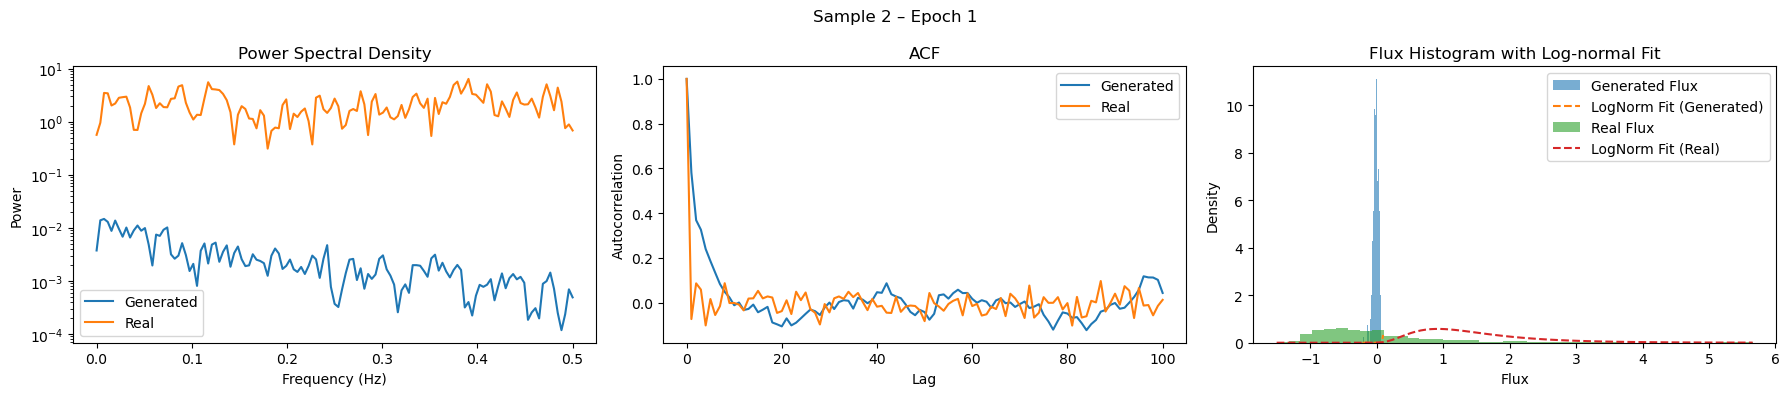

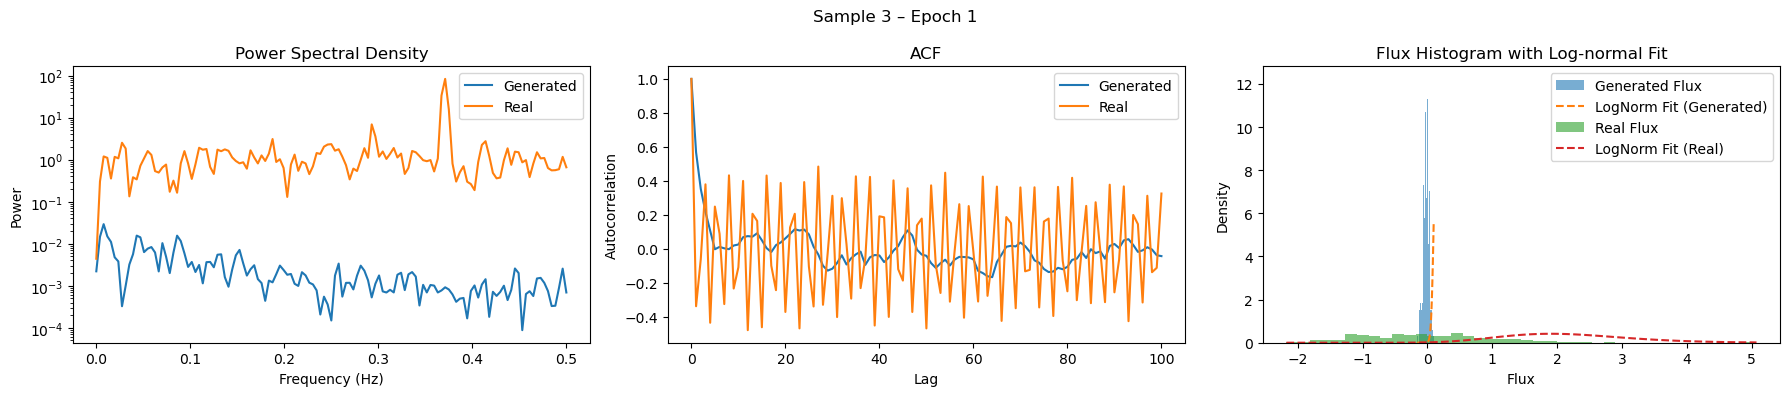

📄 Saved PDF for epoch 1 at: gan_outputs/epoch_1.pdf
✅ Logged validation losses (gen: 0.7642, disc: 1.3754)
13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - disc_loss: 1.3784 - gen_loss: 0.7495
Epoch 2/5


2025-04-07 20:53:11.755598: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 1.3774 - gen_loss: 0.7778

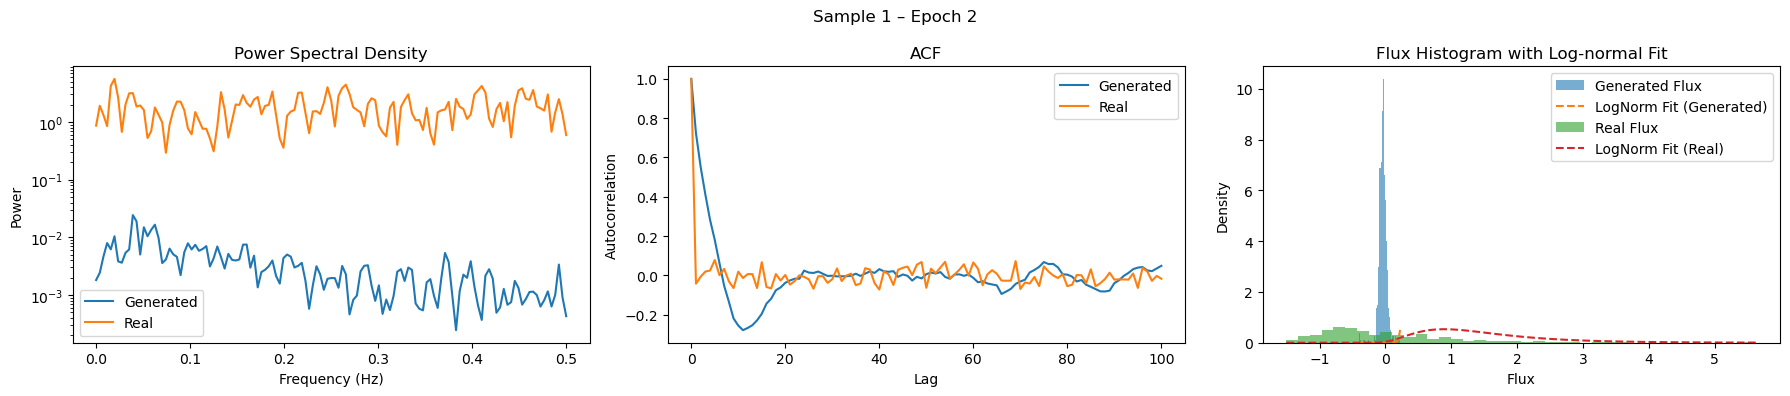

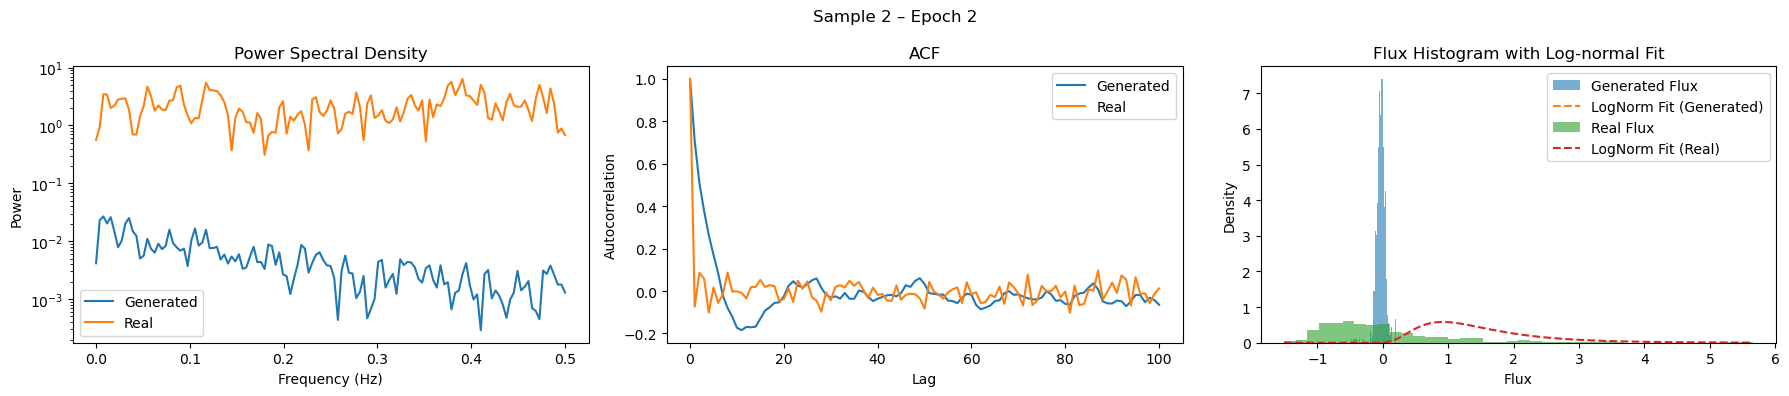

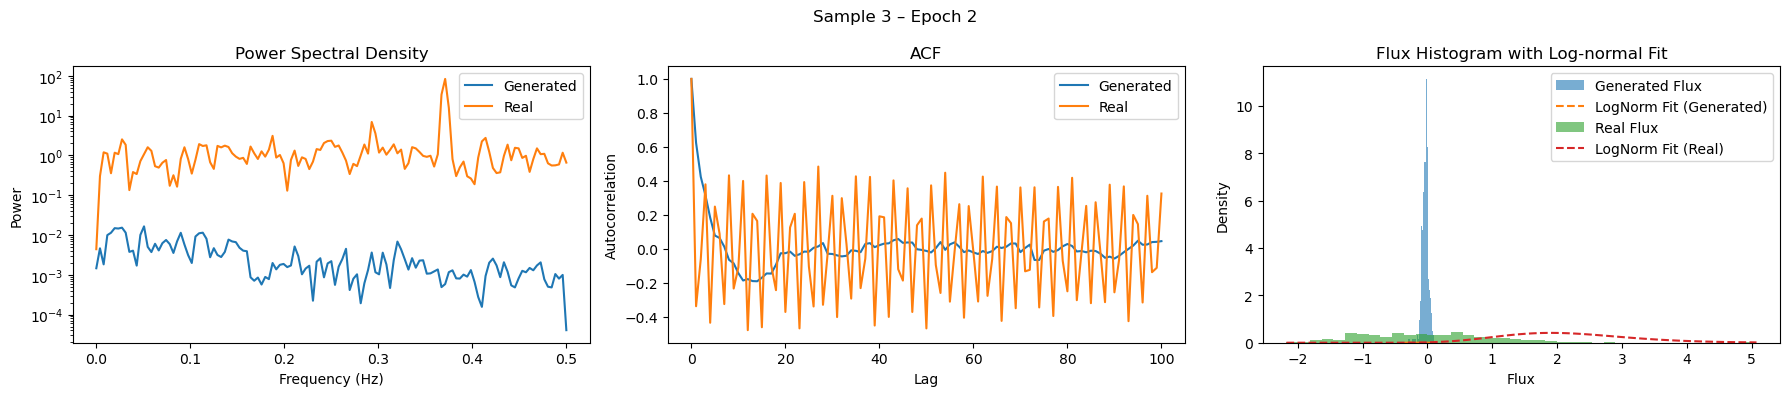

📄 Saved PDF for epoch 2 at: gan_outputs/epoch_2.pdf
✅ Logged validation losses (gen: 0.7890, disc: 1.3714)
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - disc_loss: 1.3770 - gen_loss: 0.7780
Epoch 3/5


2025-04-07 20:53:48.880179: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 1.3676 - gen_loss: 0.7984

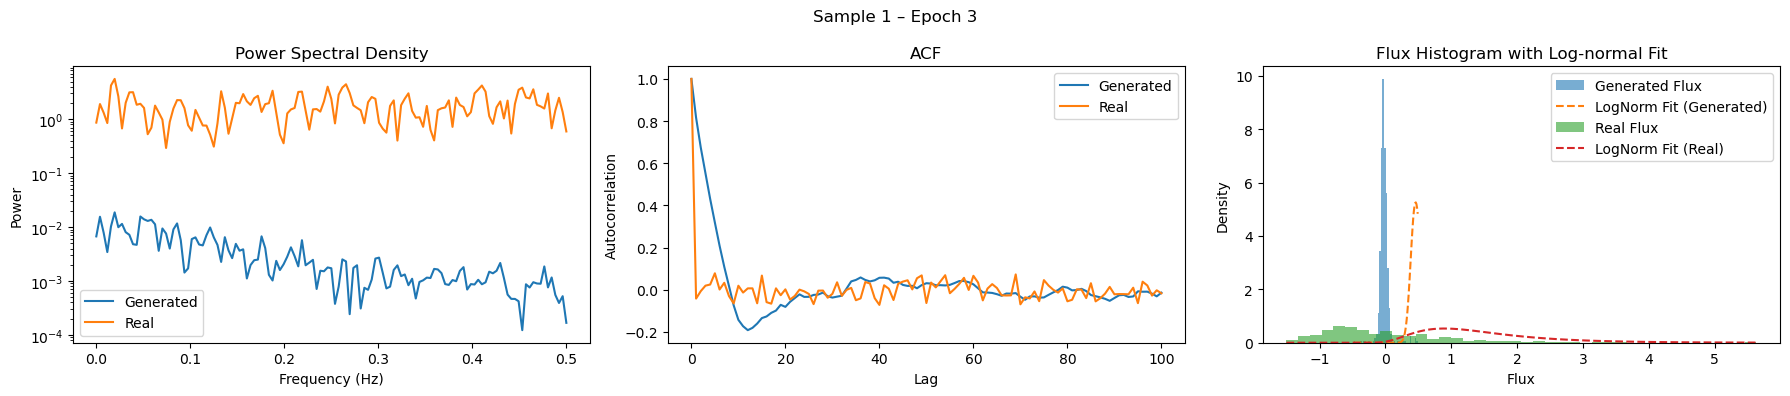

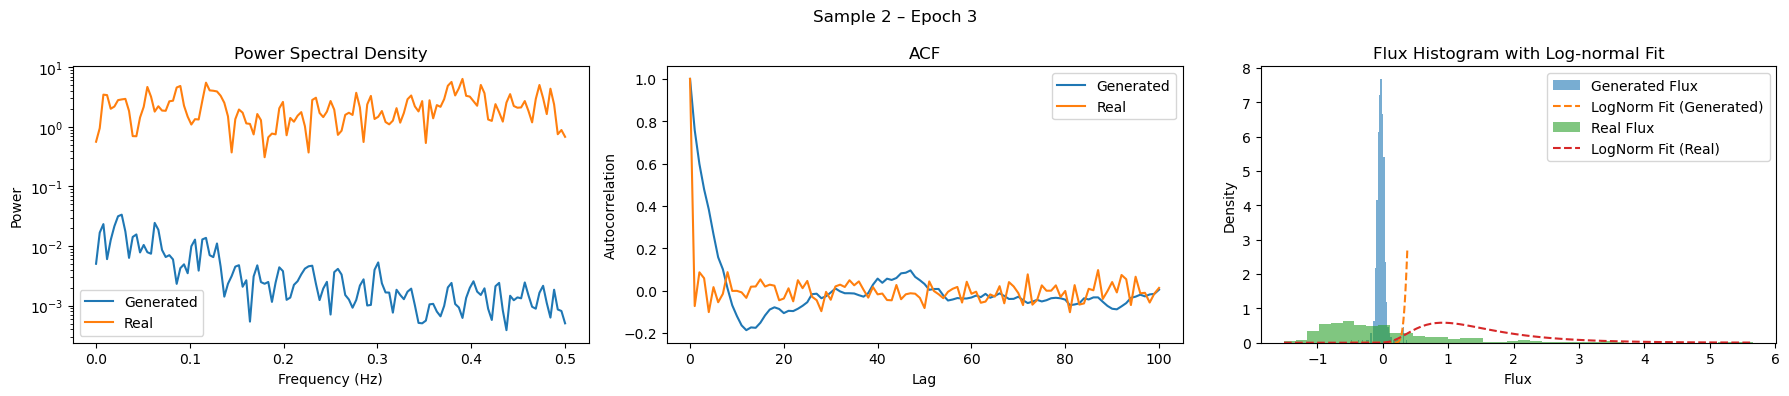

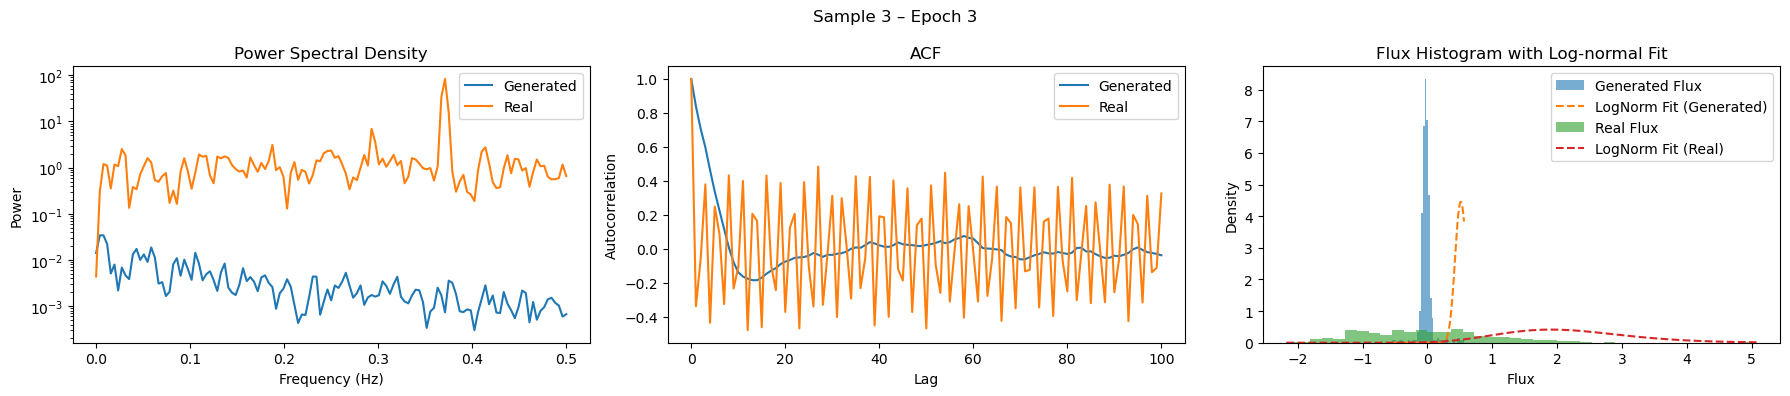

📄 Saved PDF for epoch 3 at: gan_outputs/epoch_3.pdf
✅ Logged validation losses (gen: 0.8031, disc: 1.3652)
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - disc_loss: 1.3677 - gen_loss: 0.7983
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 1.3704 - gen_loss: 0.7989

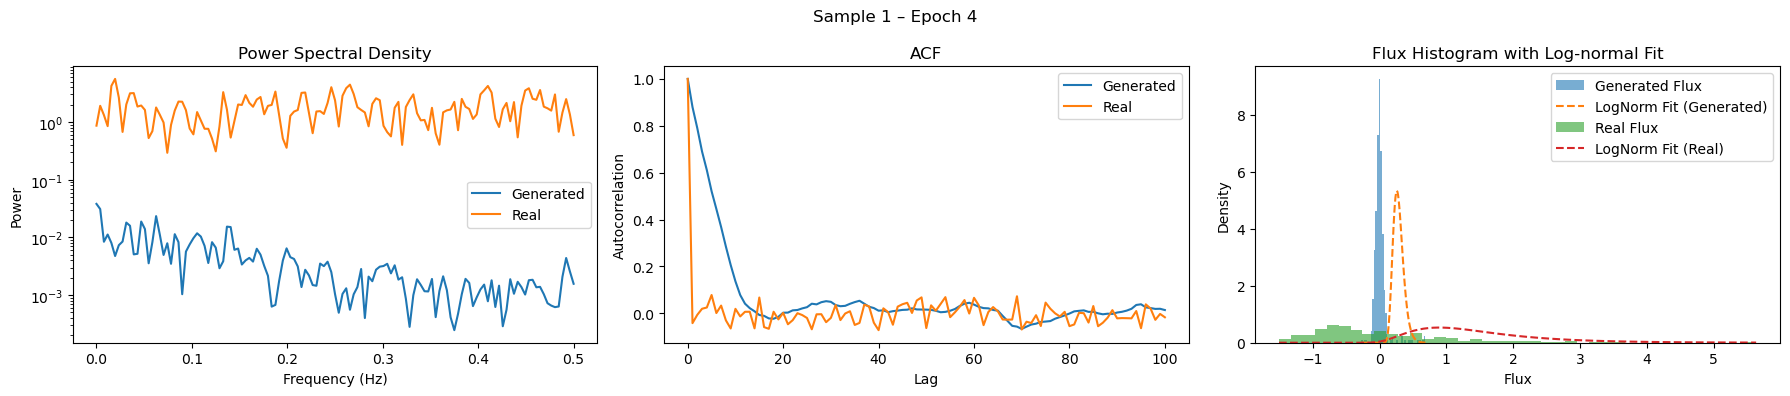

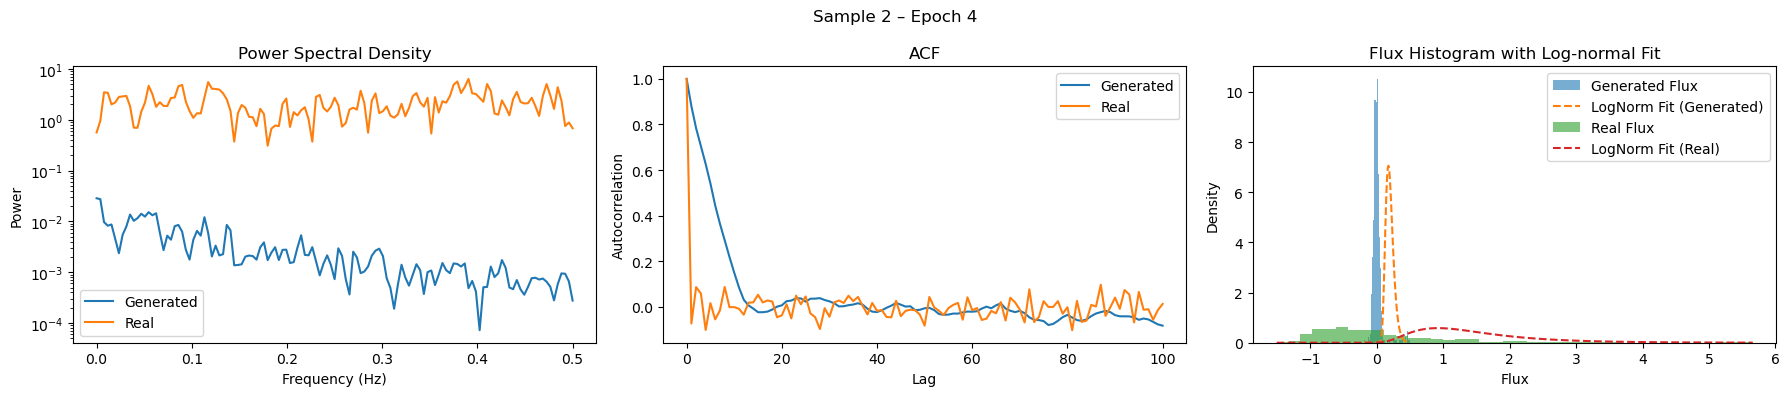

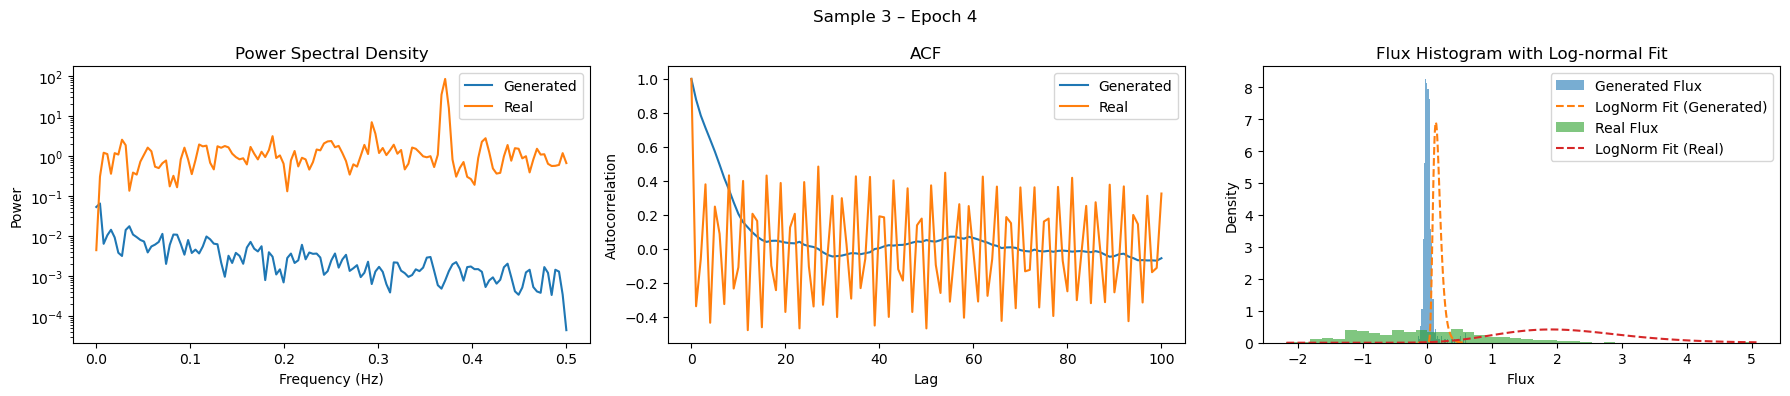

📄 Saved PDF for epoch 4 at: gan_outputs/epoch_4.pdf
✅ Logged validation losses (gen: 0.7920, disc: 1.3767)
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - disc_loss: 1.3708 - gen_loss: 0.7975
Epoch 5/5


2025-04-07 20:55:02.612807: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 1.3805 - gen_loss: 0.7863

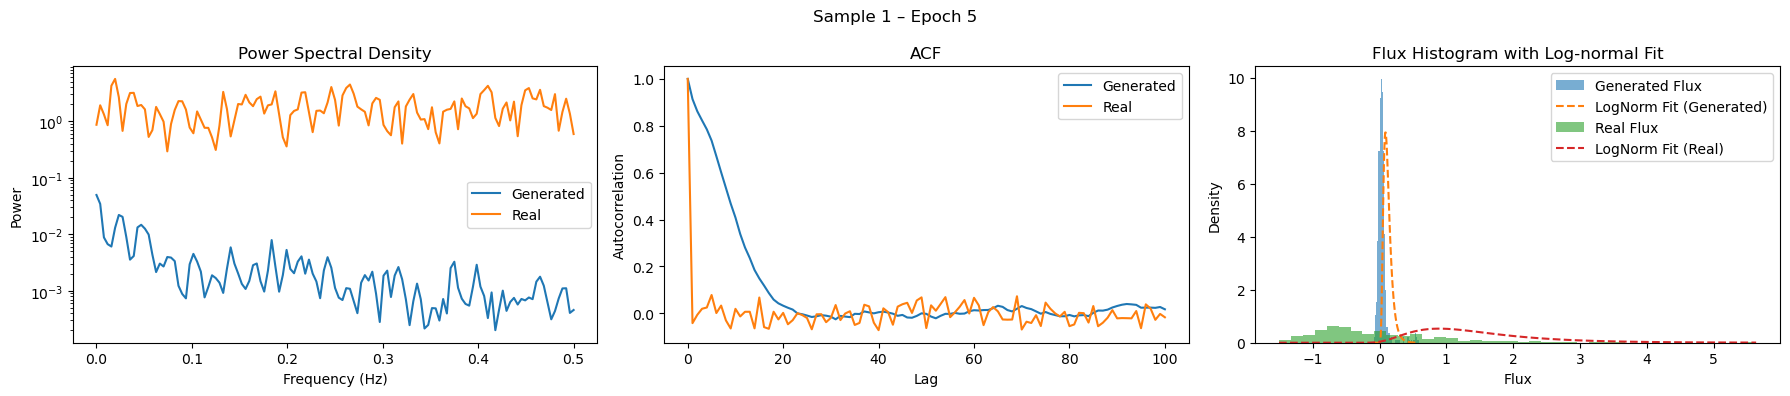

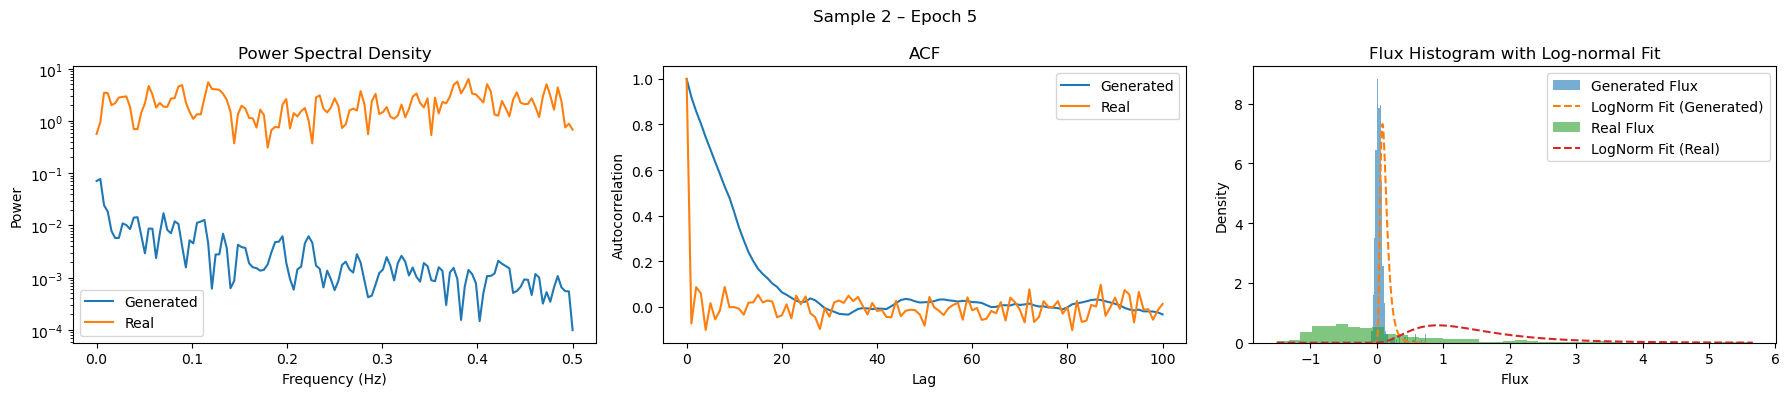

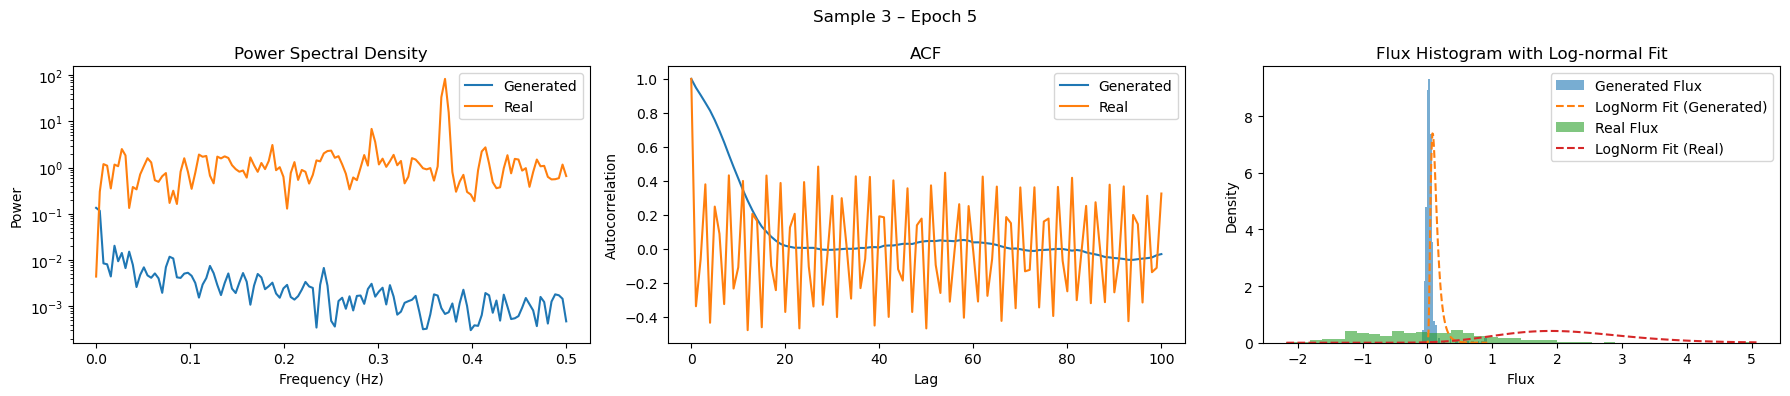

📄 Saved PDF for epoch 5 at: gan_outputs/epoch_5.pdf
✅ Logged validation losses (gen: 0.7854, disc: 1.3896)
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - disc_loss: 1.3808 - gen_loss: 0.7862


In [12]:
# Load data
train_ds, val_ds = load_physical_conditional_dataset(
    npz_path="qpo_physical_dataset/dataset_fc_amp/data_fc_amp.npz"
)

# Build models
latent_dim = 100
generator = build_full_conditional_generator(
    latent_dim=latent_dim, condition_dim=3)
discriminator = build_full_conditional_discriminator(condition_dim=3)


gan = ConditionalTimeSeriesGAN(generator, discriminator, latent_dim)
gan.compile()


monitor = GANMonitor(generator, val_dataset=val_ds,
                     # sample QPO
                     latent_dim=latent_dim, label=[0.3, 0.9, 1.0])

val_logger = ValidationLossLogger(
    val_dataset=val_ds, latent_dim=100, generator=generator, discriminator=discriminator)

gan.fit(train_ds, epochs=5, callbacks=[monitor, val_logger])

In [14]:
import os
import shutil

# Save generator and discriminator after training
# os.makedirs("saved_models", exist_ok=True)
generator.save("saved_models/qpo_cgan_phy_generator.keras")
discriminator.save("saved_models/qpo_cgan_phy_discriminator.keras")
# shutil.copyfile('./conditional_gan_training_log.csv', 'drive/MyDrive/saved_models/cgan_phy_training_log.csv')

In [ ]:
# from tensorflow.keras.models import load_model

# # Load generator and discriminator
# generator = load_model("saved_models/generator_bigru.h5", compile=False)
# discriminator = load_model("saved_models/discriminator_bigru.h5", compile=False)

# generator.summary()  # Optional check

In [ ]:
!zip -r /content/drive/MyDrive/saved_models/gan_outputs.zip /content/gan_outputs/
!zip -r /content/drive/MyDrive/saved_models/saved_models.zip /content/saved_models/
